# scplotter to work with 10x Visium HD data prepared by Giotto

See: <https://drieslab.github.io/giotto_workshop_2024/visium-hd.html>

Go back to scplotter documentation: <https://pwwang.github.io/scplotter/>

In [1]:
library(Giotto)

# Ensure Giotto can access a python env
genv_exists <- suppressMessages(checkGiottoEnvironment())
print(genv_exists)

python_path <- file.path(Sys.getenv("HOME"), "miniconda3", "envs", "giotto_env", "bin", "python")
Sys.setenv(RETICULATE_PYTHON = python_path)

invisible(capture.output(suppressMessages(set_giotto_python_path(python_path = python_path))))

# library(scplotter)
devtools::load_all()

Loading required package: GiottoClass



Giotto Suite 4.2.1



[1] TRUE


ℹ Loading scplotter


In [9]:
library(Giotto)

## Set instructions
results_folder <- "data/Human_Colorectal_Cancer_workshop.results"

instructions <- createGiottoInstructions(
    save_dir = results_folder,
    save_plot = FALSE,
    show_plot = TRUE,
    return_plot = TRUE,
    python_path = python_path
)

## Provide the path to the visium folder
data_path <- "data/Human_Colorectal_Cancer_workshop/square_002um"

expression_path <- file.path(data_path, 'raw_feature_bc_matrix')
expr_results <- get10Xmatrix(path_to_data = expression_path,
                             gene_column_index = 1)

tissue_positions_path <- file.path(data_path, 'spatial/tissue_positions.parquet')
tissue_positions <- data.table::as.data.table(arrow::read_parquet(tissue_positions_path))

matrix_tile_dt <- data.table::as.data.table(Matrix::summary(expr_results))
genes   <- expr_results@Dimnames[[1]]
samples <- expr_results@Dimnames[[2]]
matrix_tile_dt[, gene := genes[i]]
matrix_tile_dt[, pixel := samples[j]]

expr_pos_data <- data.table::merge.data.table(matrix_tile_dt,
                                             tissue_positions,
                                             by.x = 'pixel',
                                             by.y = 'barcode')

expr_pos_data <- expr_pos_data[,.(pixel, pxl_row_in_fullres, pxl_col_in_fullres, gene, x)]
colnames(expr_pos_data) = c('pixel', 'x', 'y', 'gene', 'count')

giotto_points = createGiottoPoints(x = expr_pos_data[,.(x, y, gene, pixel, count)])

hexbin400 <- tessellate(extent = ext(giotto_points),
                        shape = 'hexagon',
                        shape_size = 400,
                        name = 'hex400')

# gpoints provides spatial gene expression information
# gpolygons provides spatial unit information (here = hexagon tiles)
visiumHD = createGiottoObjectSubcellular(gpoints = list('rna' = giotto_points),
                                         gpolygons = list('hex400' = hexbin400),
                                         instructions = instructions)

# create spatial centroids for each spatial unit (hexagon)
visiumHD = addSpatialCentroidLocations(gobject = visiumHD,
                                       poly_info = 'hex400')

visiumHD

python already initialized in this session
 active environment : 'giotto_env'
 python version : 3.10



Warning message:
“Potentially unsafe or invalid elements have been discarded from R metadata.
ℹ Type: "externalptr"
→ If you trust the source, you can set `options(arrow.unsafe_metadata = TRUE)` to preserve them.”
  Selecting col "gene" as feat_ID column

  Selecting cols "x" and "y" as x and y respectively

367 polygons generated

polygonlist is a list with names

[ hex400 ] Process polygon info...

pointslist is a named list

[ rna ] Process point info...

Start centroid calculation for polygon information
 layer: hex400



An object of class giotto 
[SUBCELLULAR INFO]
polygons      : hex400 
features      : rna 
[AGGREGATE INFO]
spatial locations ----------------
  [hex400] raw


Use objHistory() to see steps and params used

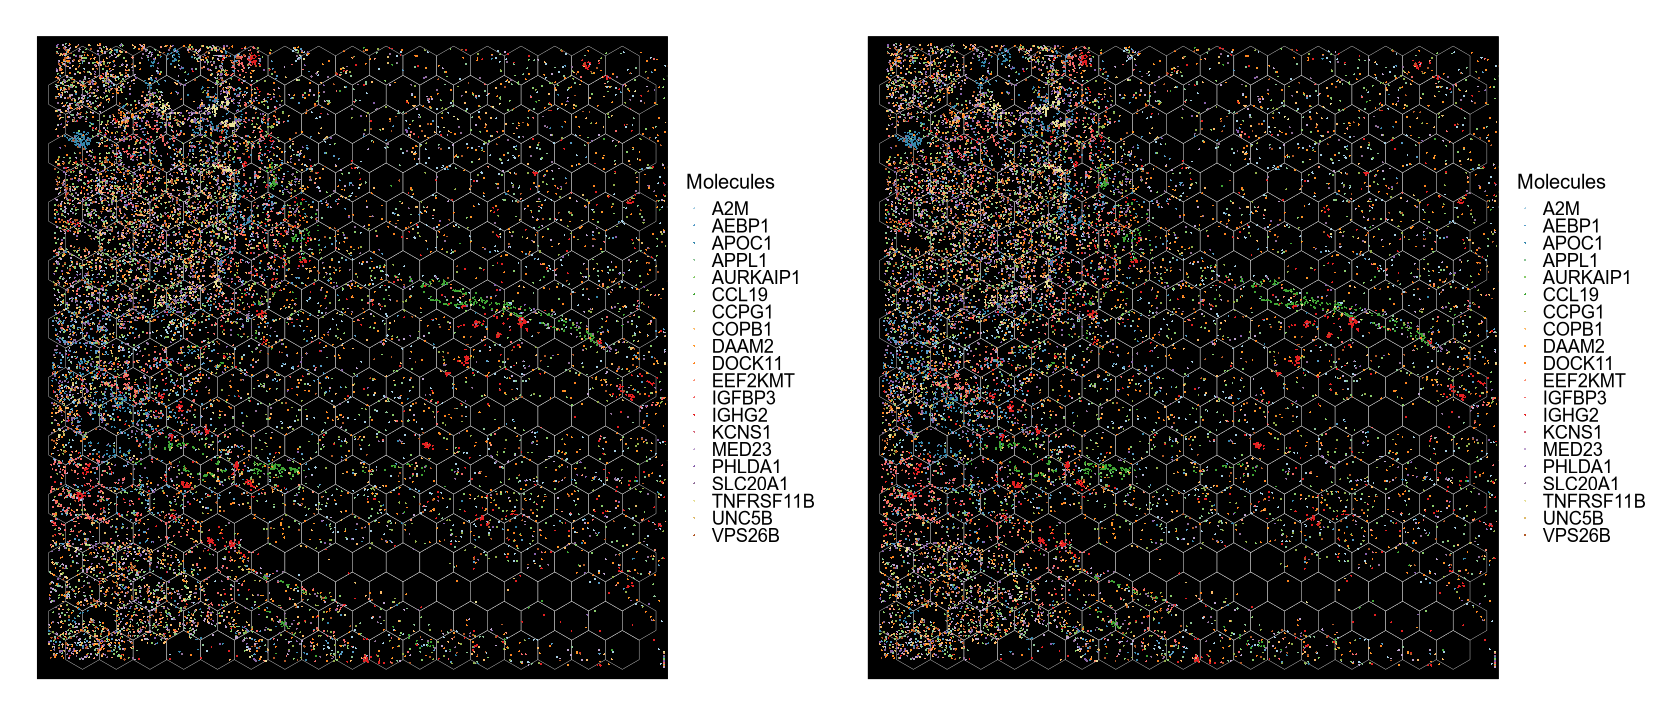

In [25]:
options(repr.plot.width = 14, repr.plot.height = 6)
# devtools::load_all()

p1 <- SpatDimPlot(
    visiumHD,
    image = "black",
    shapes = TRUE,
    features = GiottoClass::featIDs(visiumHD, 'rna')[1:20],
    spat_unit = 'hex400',
    shapes_feat_type = 'hex400',
    shapes_border_size = 0.1,
    shapes_border_color = "white",
    shapes_fill_by = "black",
    shapes_alpha = 0.5,
    points_size = 0.25
)
p2 <- SpatDimPlot(
    visiumHD,
    image = "black",
    shapes = TRUE,
    features = GiottoClass::featIDs(visiumHD, 'rna')[1:20],
    spat_unit = 'hex400',
    shapes_feat_type = 'hex400',
    shapes_border_size = 0.1,
    shapes_border_color = "white",
    shapes_fill_by = "black",
    shapes_alpha = 0.5,
    points_size = 0.25,
    raster = TRUE
)
p1 + p2

In [26]:
visiumHD = calculateOverlap(visiumHD,
                            spatial_info = 'hex400',
                            feat_info = 'rna')
# convert overlap results to bin by gene matrix
visiumHD = overlapToMatrix(visiumHD,
                           poly_info = 'hex400',
                           feat_info = 'rna',
                           name = 'raw')

# this action will automatically create an active spatial unit, ie. hexbin 400
activeSpatUnit(visiumHD)

# filter on gene expression matrix
visiumHD <- filterGiotto(visiumHD,
                         expression_threshold = 1,
                         feat_det_in_min_cells = 5,
                         min_det_feats_per_cell = 25)

# normalize and scale gene expression data
visiumHD <- normalizeGiotto(visiumHD,
                            scalefactor = 1000,
                            verbose = T)

# add cell and gene statistics
visiumHD <- addStatistics(visiumHD)

1. convert polygon to raster

2. overlap raster and points

3. add polygon information

4. add points information

5. create overlap polygon
 information



[1] "hex400"

completed 1: preparation

completed 2: subset expression data

completed 3: subset spatial locations

completed 4: subset cell metadata

completed 5: subset feature metadata

completed 6: subset spatial network(s)

completed 7: subsetted dimension reductions

completed 8: subsetted nearest network(s)

completed 9: subsetted spatial enrichment results

for hex400

--> hex400 found back in polygon layer: hex400

completed 10: subsetted spatial information data

subset feature info: rna

completed 11: subsetted spatial feature data




Feature type:  rna 
Number of cells removed:  0  out of  367 
Number of feats removed:  349  out of  4967 


first scale feats and then cells

Setting expression [hex400][rna] normalized

Setting expression [hex400][rna] scaled

calculating statistics for "normalized" expression



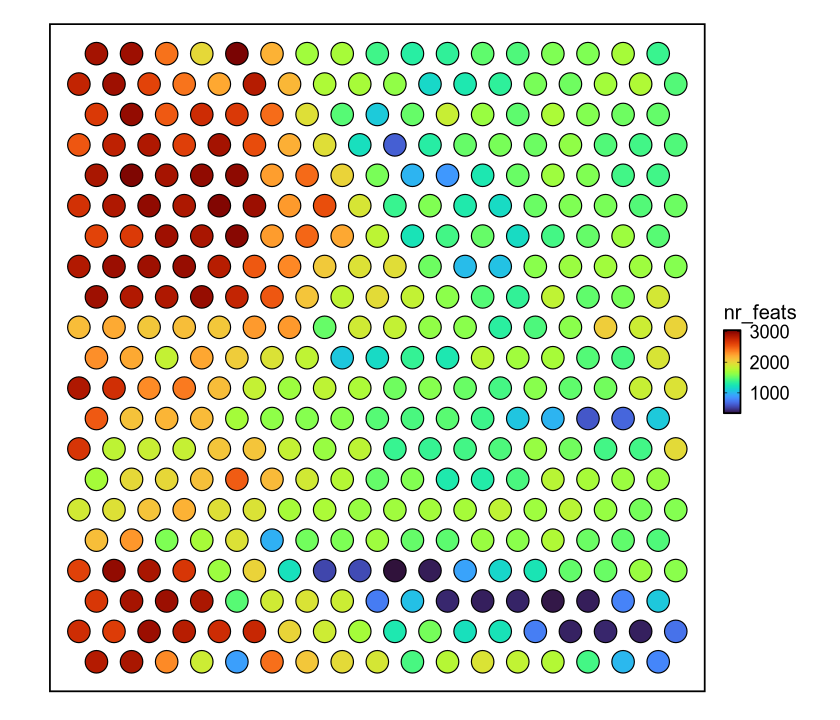

In [30]:
options(repr.plot.width = 7, repr.plot.height = 6)

SpatFeaturePlot(
    visiumHD,
    features = "nr_feats",
    points_size = 6,
    points_shape = 21
)

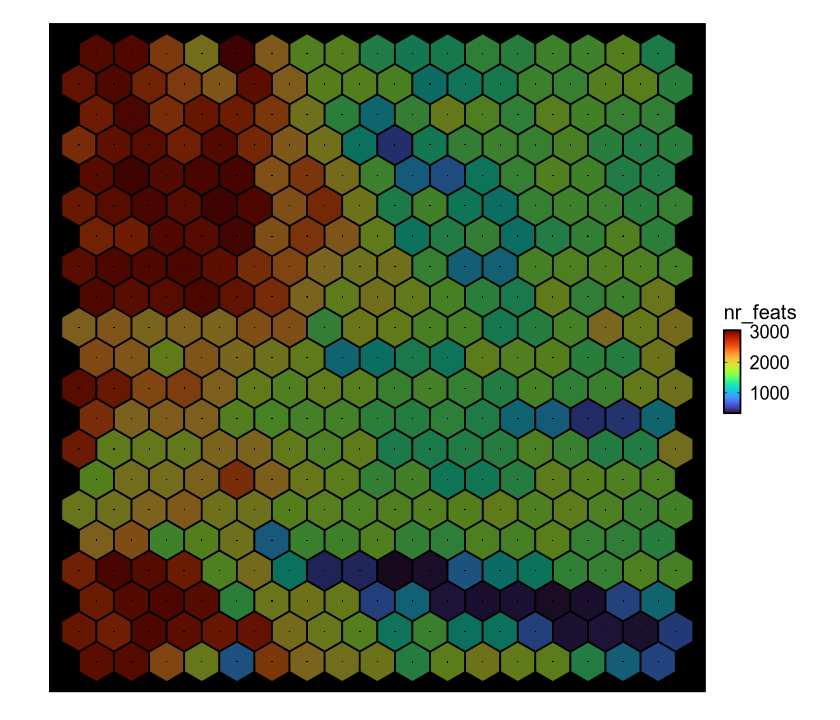

In [34]:
options(repr.plot.width = 7, repr.plot.height = 6)

SpatFeaturePlot(
    visiumHD,
    image = "black",
    shapes = TRUE,
    spat_unit = 'hex400',
    use_overlap = TRUE,
    shapes_fill_by = "nr_feats",
    shapes_feat_type = 'hex400',
    points_size = 0.1
)

In [35]:
visiumHD <- calculateHVF(visiumHD,
                         zscore_threshold = 1)
visiumHD <- runPCA(visiumHD,
                   expression_values = 'normalized',
                   feats_to_use = 'hvf')
visiumHD <- runUMAP(visiumHD,
                    dimensions_to_use = 1:14,
                    n_threads = 10)
# sNN network (default)
visiumHD <- createNearestNetwork(visiumHD,
                                 dimensions_to_use = 1:14,
                                 k = 5)

## leiden clustering ####
visiumHD <- doLeidenClusterIgraph(visiumHD, resolution = 0.5, n_iterations = 1000, spat_unit = 'hex400')

"hvf" column was found in the feats metadata information and will be
 used to select highly variable features

Setting dimension reduction [hex400][rna] pca

Setting dimension reduction [hex400][rna] umap



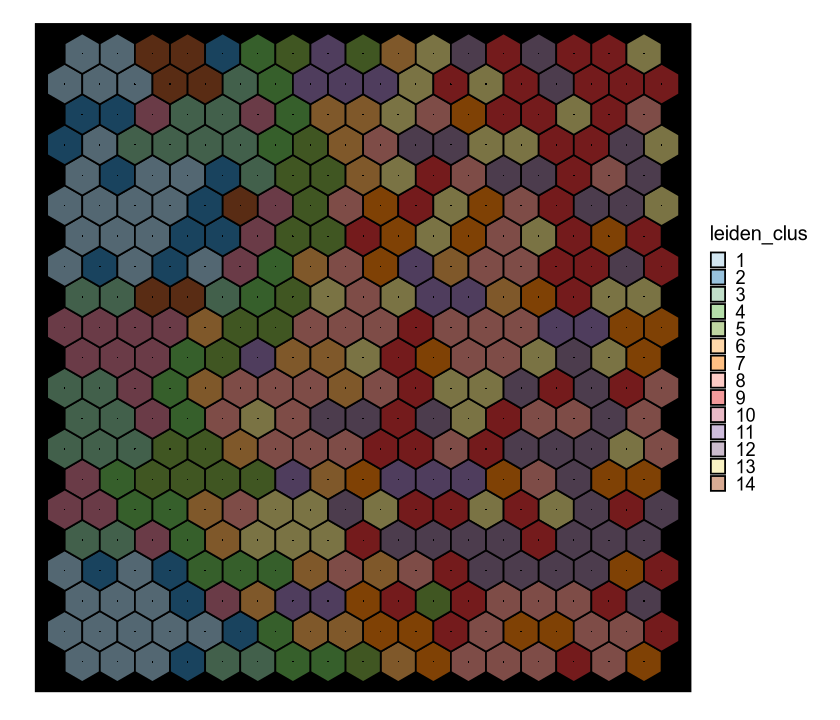

In [37]:
options(repr.plot.width = 7, repr.plot.height = 6)

visiumHD@cell_metadata$hex400$rna$leiden_clus <- as.factor(visiumHD@cell_metadata$hex400$rna$leiden_clus)

SpatFeaturePlot(
    visiumHD,
    image = "black",
    shapes = TRUE,
    spat_unit = 'hex400',
    shapes_fill_by = "leiden_clus",
    shapes_feat_type = 'hex400',
    points_size = 0.1
)